In [1]:
# /**
# *                   _oo0oo_
# *                  o8888888o
# *                  88" . "88
# *                  (| -_- |)
# *                  0\  =  /0
# *                ___/`---'\___
# *              .' \\|     |// '.
# *             / \\|||  :  |||// \
# *            / _||||| -:- |||||- \
# *           |   | \\\  -  /// |   |
# *           | \_|  ''\---/''  |_/ |
# *           \  .-\__  '-'  ___/-. /
# *         ___'. .'  /--.--\  `. .'___
# *      ."" '<  `.___\_<|>_/___.' >' "".
# *     | | :  `- \`.;`\ _ /`;.`/ - ` : | |
# *     \  \ `_.   \_ __\ /__ _/   .-` /  /
# * =====`-.____`.___ \_____/___.-`___.-'=====
# *                   `=---='
# *
# *
# * ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# *
# *   Buddha blesses your code to be bug free
# */

**Please note that this project is also influenced by a kaggle article:** [reference](https://www.kaggle.com/code/mgmarques/wines-type-and-quality-classification-exercises#notebook-container)

In [2]:
!pip install git+https://github.com/oracle/Skater.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/oracle/Skater.git to /tmp/pip-req-build-jiy0awi5
  Running command git clone -q https://github.com/oracle/Skater.git /tmp/pip-req-build-jiy0awi5
     |████████████████████████████████| 275 kB 4.9 MB/s 
  Created wheel for skater: filename=skater-1.1.2b1-py3-none-any.whl size=4637019 sha256=a49559bcb4a4e4ecae52fab0926522191764276406f097bd465f43028995f066
  Stored in directory: /tmp/pip-ephem-wheel-cache-1nrikaau/wheels/bc/e1/05/2b5d1c01d1e582236157f04b759d2e140ccc6703f599148c72
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=e52dd0e61bf02dd5f9d197c8969396cd1fdd5d41afd9ea936c2622d64e57257f
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built skater lime


In [3]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import numpy as np
import pandas as pd
import pylab 
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
%matplotlib inline
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from graphviz import Source
from IPython.display import Image

from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from scipy import interp
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin
from sklearn import metrics, tree
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, PolynomialFeatures, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
#from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingClassifier
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

## Load the datasets

In [4]:
from google.colab import files
dataset_file_dict = files.upload()

Saving winequality-red.csv to winequality-red.csv
Saving winequality-white.csv to winequality-white.csv


In [5]:
red = pd.read_csv("/content/winequality-red.csv", sep=';')
white = pd.read_csv("/content/winequality-white.csv", sep=';')

In [6]:
#add type column for white or red wine
red['type'] = 'red'
white['type'] = 'white'

In [7]:
#merge datasets
wine_data = pd.concat([red,white])

In [8]:
wine_data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'type'],
      dtype='object')

### Quality Score:


*   Low: <=5
*   Medium: 6>= x =<7
*  High: >7



In [9]:
wine_data['quality_label'] = wine_data['quality'].apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')
#shuffle data
wine_data = wine_data.sample(frac=1, random_state=101).reset_index(drop=True)

In [10]:
wine_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,quality_label
0,6.8,0.56,0.22,1.8,0.074,15.0,24.0,0.99438,3.40,0.82,11.2,6,red,medium
1,6.4,0.30,0.36,2.0,0.052,18.0,141.0,0.99273,3.38,0.53,10.5,6,white,medium
2,5.9,0.17,0.29,3.1,0.030,32.0,123.0,0.98913,3.41,0.33,13.7,7,white,medium
3,7.0,0.24,0.24,1.8,0.047,29.0,91.0,0.99251,3.30,0.43,9.9,6,white,medium
4,6.4,0.45,0.07,1.1,0.030,10.0,131.0,0.99050,2.97,0.28,10.8,5,white,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,12.7,0.59,0.45,2.3,0.082,11.0,22.0,1.00000,3.00,0.70,9.3,6,red,medium
6493,8.0,0.25,0.35,1.1,0.054,13.0,136.0,0.99366,3.08,0.55,9.5,5,white,low
6494,8.3,0.85,0.14,2.5,0.093,13.0,54.0,0.99724,3.36,0.54,10.1,5,red,low
6495,6.3,0.60,0.10,1.6,0.048,12.0,26.0,0.99306,3.55,0.51,12.1,5,red,low


## Data Summary Statistics and Data Cleaning

In [11]:
#null checks
wine_data.apply(lambda x: x.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
quality_label           0
dtype: int64

In [12]:
wine_data.quality_label.value_counts()

medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

In [13]:
wine_data.dropna().quality_label.value_counts()

medium    3915
low       2384
high       198
Name: quality_label, dtype: int64

There are no null values -> we don't lose any data

In [14]:
#check data types
wine_data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
type                     object
quality_label            object
dtype: object

### Check the distribution of data between wine qualities and wine types

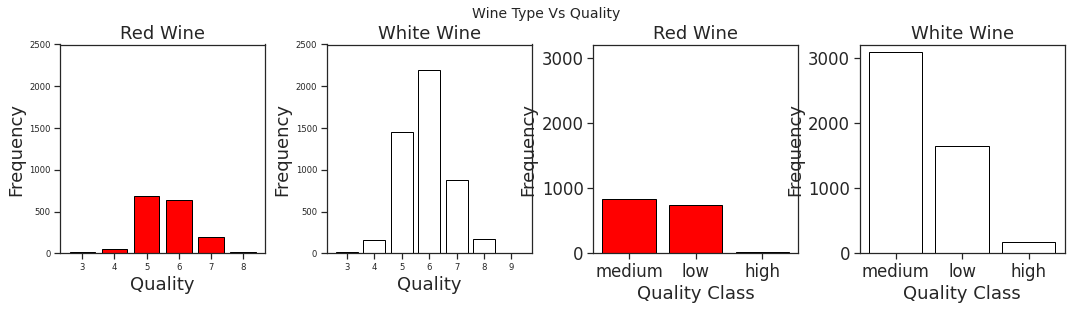

In [15]:
fig = plt.figure(figsize = (18, 4))
title = fig.suptitle("Wine Type Vs Quality", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,4, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Quality")
ax1.set_ylabel("Frequency") 
rw_q = wine_data.quality[wine_data.type == 'red'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax1.set_ylim([0, 2500])
ax1.tick_params(axis='both', which='major', labelsize=8.5)
bar1 = ax1.bar(rw_q[0], rw_q[1], color='red', edgecolor='black', linewidth=1)


ax2 = fig.add_subplot(1,4, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Quality")
ax2.set_ylabel("Frequency") 
ww_q = wine_data.quality[wine_data.type == 'white'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax2.set_ylim([0, 2500])
ax2.tick_params(axis='both', which='major', labelsize=8.5)
bar2 = ax2.bar(ww_q[0], ww_q[1], color='white', edgecolor='black', linewidth=1)

ax3 = fig.add_subplot(1,4, 3)
ax3.set_title("Red Wine")
ax3.set_xlabel("Quality Class")
ax3.set_ylabel("Frequency") 
rw_q = wine_data.quality_label[wine_data.type == 'red'].value_counts()
rw_q = (list(rw_q.index), list(rw_q.values))
ax3.set_ylim([0, 3200])
bar3 = ax3.bar(list(range(len(rw_q[0]))), rw_q[1], color='red', edgecolor='black', linewidth=1, tick_label =rw_q[0])

ax4 = fig.add_subplot(1,4, 4)
ax4.set_title("White Wine")
ax4.set_xlabel("Quality Class")
ax4.set_ylabel("Frequency") 
ww_q = wine_data.quality_label[wine_data.type == 'white'].value_counts()
ww_q = (list(ww_q.index), list(ww_q.values))
ax4.set_ylim([0, 3200])
bar4 = ax4.bar(list(range(len(ww_q[0]))), ww_q[1], color='white', edgecolor='black', linewidth=1, tick_label =ww_q[0])

There is an imbalance between classes of quality, as we can see for example "high" quality wines are very few in comparison to medium and low quality wines.

### Descriptive statistics

By type:

In [16]:
subset_attributes = wine_data.columns
rs = round(wine_data.loc[wine_data.type == 'red', subset_attributes].describe(),2)
ws = round(wine_data.loc[wine_data.type == 'white', subset_attributes].describe(),2)
pd.concat([rs, ws], axis=0, keys=['Red Wine Statistics', 'White Wine Statistics']).T

Red Wine Statistics                                    \
                                   count   mean    std   min    25%    50%   
fixed acidity                     1599.0   8.32   1.74  4.60   7.10   7.90   
volatile acidity                  1599.0   0.53   0.18  0.12   0.39   0.52   
citric acid                       1599.0   0.27   0.19  0.00   0.09   0.26   
residual sugar                    1599.0   2.54   1.41  0.90   1.90   2.20   
chlorides                         1599.0   0.09   0.05  0.01   0.07   0.08   
free sulfur dioxide               1599.0  15.87  10.46  1.00   7.00  14.00   
total sulfur dioxide              1599.0  46.47  32.90  6.00  22.00  38.00   
density                           1599.0   1.00   0.00  0.99   1.00   1.00   
pH                                1599.0   3.31   0.15  2.74   3.21   3.31   
sulphates                         1599.0   0.66   0.17  0.33   0.55   0.62   
alcohol                           1599.0  10.42   1.07  8.40   9.50  10.20   
quality                           1599.0   5.64   0.81  3.00   5.00   6.00   

                                    White Wine Statistics                 \
                        75%     max                 count    mean    std   
fixed acidity          9.20   15.90                4898.0    6.85   0.84   
volatile acidity       0.64    1.58                4898.0    0.28   0.10   
citric acid            0.42    1.00                4898.0    0.33   0.12   
residual sugar         2.60   15.50                4898.0    6.39   5.07   
chlorides              0.09    0.61                4898.0    0.05   0.02   
free sulfur dioxide   21.00   72.00                4898.0   35.31  17.01   
total sulfur dioxide  62.00  289.00                4898.0  138.36  42.50   
density                1.00    1.00                4898.0    0.99   0.00   
pH                     3.40    4.01                4898.0    3.19   0.15   
sulphates              0.73    2.00                4898.0    0.49   0.11   
alcohol               11.10   14.90                4898.0   10.51   1.23   
quality                6.00    8.00                4898.0    5.88   0.89   

                                                            
                       min     25%     50%     75%     max  
fixed acidity         3.80    6.30    6.80    7.30   14.20  
volatile acidity      0.08    0.21    0.26    0.32    1.10  
citric acid           0.00    0.27    0.32    0.39    1.66  
residual sugar        0.60    1.70    5.20    9.90   65.80  
chlorides             0.01    0.04    0.04    0.05    0.35  
free sulfur dioxide   2.00   23.00   34.00   46.00  289.00  
total sulfur dioxide  9.00  108.00  134.00  167.00  440.00  
density               0.99    0.99    0.99    1.00    1.04  
pH                    2.72    3.09    3.18    3.28    3.82  
sulphates             0.22    0.41    0.47    0.55    1.08  
alcohol               8.00    9.50   10.40   11.40   14.20  
quality               3.00    5.00    6.00    6.00    9.00

Highlights from descriptive statisct of quality perspective above:

*   It is interesting how alcohol does not give us much variation to distinguish whether the vine is white or red, but it makes a lot of difference in quality. Note that the higher the quality the higher the average alcohol concentration, increased by about 1% at each level. Although lower quality wines have the lowest standard deviation.
*   The chlorides and volatile acidity are less present and presented smaller standard deviation in wines of higher quality.
*  The free sulfur dioxide is higher with higher quality, but their standard deviation decrease with the increase the quality.
* Higher quality has less fixed acidity, but the standard deviation is slightly higher in mean quality




By quality:

In [17]:
ls = round(wine_data[wine_data['quality_label'] == 'low'][subset_attributes].describe(),2)
ms = round(wine_data[wine_data['quality_label'] == 'medium'][subset_attributes].describe(),2)
hs = round(wine_data[wine_data['quality_label'] == 'high'][subset_attributes].describe(),2)
pd.concat([ls, ms, hs], axis=0, keys=['Low Quality Wine', 'Medium Quality Wine', 'High Quality Wine']).T

Low Quality Wine                                      \
                                count    mean    std   min    25%     50%   
fixed acidity                  2384.0    7.33   1.27  4.20   6.50    7.10   
volatile acidity               2384.0    0.40   0.19  0.10   0.26    0.34   
citric acid                    2384.0    0.30   0.16  0.00   0.21    0.30   
residual sugar                 2384.0    5.65   4.92  0.60   1.80    2.90   
chlorides                      2384.0    0.06   0.04  0.01   0.04    0.05   
free sulfur dioxide            2384.0   29.48  19.84  2.00  14.00   26.00   
total sulfur dioxide           2384.0  119.28  61.89  6.00  68.00  124.00   
density                        2384.0    1.00   0.00  0.99   0.99    1.00   
pH                             2384.0    3.21   0.16  2.74   3.11    3.20   
sulphates                      2384.0    0.52   0.14  0.25   0.44    0.50   
alcohol                        2384.0    9.87   0.84  8.00   9.30    9.60   
quality                        2384.0    4.88   0.36  3.00   5.00    5.00   

                                     Medium Quality Wine          ...          \
                         75%     max               count    mean  ...     75%   
fixed acidity           7.80   15.90              3915.0    7.16  ...    7.60   
volatile acidity        0.50    1.58              3915.0    0.31  ...    0.36   
citric acid             0.40    1.00              3915.0    0.33  ...    0.39   
residual sugar          8.52   23.50              3915.0    5.32  ...    7.90   
chlorides               0.08    0.61              3915.0    0.05  ...    0.06   
free sulfur dioxide    42.00  289.00              3915.0   30.96  ...   41.00   
total sulfur dioxide  167.00  440.00              3915.0  113.51  ...  150.00   
density                 1.00    1.00              3915.0    0.99  ...    1.00   
pH                      3.31    3.90              3915.0    3.22  ...    3.33   
sulphates               0.58    2.00              3915.0    0.54  ...    0.61   
alcohol                10.40   14.90              3915.0   10.81  ...   11.70   
quality                 5.00    5.00              3915.0    6.28  ...    7.00   

                             High Quality Wine                               \
                         max             count    mean    std    min    25%   
fixed acidity          15.60             198.0    6.85   1.14   3.90   6.20   
volatile acidity        1.04             198.0    0.29   0.12   0.12   0.21   
citric acid             1.66             198.0    0.33   0.10   0.03   0.28   
residual sugar         65.80             198.0    5.35   4.16   0.80   2.00   
chlorides               0.42             198.0    0.04   0.02   0.01   0.03   
free sulfur dioxide   112.00             198.0   34.51  17.08   3.00  24.00   
total sulfur dioxide  294.00             198.0  117.48  41.69  12.00  96.00   
density                 1.04             198.0    0.99   0.00   0.99   0.99   
pH                      4.01             198.0    3.23   0.16   2.88   3.13   
sulphates               1.95             198.0    0.51   0.16   0.25   0.38   
alcohol                14.20             198.0   11.69   1.27   8.50  11.00   
quality                 7.00             198.0    8.03   0.16   8.00   8.00   

                                              
                         50%     75%     max  
fixed acidity           6.80    7.30   12.60  
volatile acidity        0.28    0.35    0.85  
citric acid             0.32    0.37    0.74  
residual sugar          4.05    7.57   14.80  
chlorides               0.04    0.04    0.12  
free sulfur dioxide    34.00   43.00  105.00  
total sulfur dioxide  118.50  145.00  212.50  
density                 0.99    0.99    1.00  
pH                      3.23    3.33    3.72  
sulphates               0.48    0.60    1.10  
alcohol                12.00   12.60   14.00  
quality                 8.00    8.00    9.00  

[12 rows x 24 columns]

Highlights from descriptive statisct of type perspective above:

*   Mean residual sugar and total sulfur dioxide content in white wine seems to be much higher than red wine.
*   Mean value of sulphates, fixed acidity and volatile acidity seem to be higher in red wine as compared to white wine.
*  In general, white wines has half concentrations of chlorides then red wines.
* From all numbers, we can observe that citric acid is more present in white than red wines.
* Although in Ph the difference seems small it is interesting to note that it is slightly larger in green red wines.




### Prepare type and quality label target variable

In [18]:
class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(wine_data.type.values) # 1 - White; 0 - Red
wine_data['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2} 
y_ql = wine_data.quality_label.map(class_ql)

### Split the data into train and test for **Wine type classifier model**

In [47]:
cols = wine_data.columns
cols = list(cols.drop(['type', 'quality_label', 'color']))
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(wine_data.loc[:, cols], y_tp, test_size=0.20, random_state=101)

In [48]:
X_train_c['y_train'] = y_train_c.tolist()

In [49]:
X_test_c['y_test'] = y_test_c.tolist()

Export the datasets to csv

In [50]:
from google.colab import files

X_train_c.to_csv('X_train_c.csv', encoding = 'utf-8-sig') 
files.download('X_train_c.csv')
X_test_c.to_csv('X_test_c.csv', encoding = 'utf-8-sig') 
files.download('X_test_c.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Split the data into train and test for **Wine quality regression model**

In [51]:
wqp_class_labels = np.array(wine_data['quality_label'])
target_names = ['low', 'medium', 'high']

cols = wine_data.columns
cols = list(cols.drop(['type', 'quality_label', 'quality']))
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(wine_data.loc[:, cols], y_ql.values, test_size=0.20, random_state=101)

In [52]:
X_train_r['y_train'] = y_train_r.tolist()

In [53]:
X_test_r['y_test'] = y_test_r.tolist()

Export the datasets to csv

In [54]:
from google.colab import files

X_train_r.to_csv('X_train_r.csv', encoding = 'utf-8-sig') 
files.download('X_train_r.csv')
X_test_r.to_csv('X_test_r.csv', encoding = 'utf-8-sig') 
files.download('X_test_r.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
#export also the dataset 
wine_data.to_csv('wine_data.csv', encoding = 'utf-8-sig') 
files.download('wine_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>